In [1]:
import datetime
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import mplfinance as mpf
from dateutil.parser import parse
from dataset import Dataset
from portfolio import Portfolio

In [2]:
tf_hours = 1

start_date = parse('2023-01-01')
end_date = datetime.datetime.now()
days = (end_date - start_date).days
print(f'{days = }')

data = Dataset().get_data(ticker='BTCUSDT', interval=f'{tf_hours}h', start_date=start_date.strftime('%Y-%m-%d'),
                          end_date=end_date.strftime('%Y-%m-%d'))

days = 230


In [3]:
data = data[['open', 'high', 'low', 'close']]

In [4]:
data['candle_size'] = data['high'] - data['low']
data['candle_size_mean'] = data['candle_size'].rolling(14).mean()
data['candle_size_std'] = data['candle_size'].rolling(14).std()
data['std_ratio'] = (data['candle_size'] - data['candle_size_mean']) / data['candle_size_std']

In [5]:
data.tail()

,open,high,low,close,candle_size,candle_size_mean,candle_size_std,std_ratio
time,,,,,,,,
2023-08-18 21:00:00,26065.01,26243.80,26049.02,26083.78,194.78,233.730000,124.299111,-0.313357
2023-08-18 22:00:00,26083.77,26177.70,26062.74,26062.75,114.96,234.480714,123.487340,-0.967878
2023-08-18 23:00:00,26062.75,26120.44,26040.14,26071.99,80.30,227.751429,129.430659,-1.139231
2023-08-19 00:00:00,26071.99,26094.49,26006.01,26054.00,88.48,220.940714,134.335366,-0.986045
2023-08-19 01:00:00,26054.00,26154.57,26017.68,26099.09,136.89,224.956429,130.608270,-0.674279


In [6]:
data['std_ratio'].max()

3.4548606753808295

In [7]:
std_multiple = 3
data_high_vol = data[data['std_ratio'] >= std_multiple]

In [8]:
data_high_vol.head()

,open,high,low,close,candle_size,candle_size_mean,candle_size_std,std_ratio
time,,,,,,,,
2023-01-02 04:00:00,16587.99,16707.25,16581.80,16661.94,125.45,36.592143,27.043775,3.285705
2023-01-03 15:00:00,16725.53,16773.00,16631.95,16661.23,141.05,41.395000,31.073023,3.207123
2023-01-06 14:00:00,16730.65,16817.00,16679.00,16774.19,138.00,43.005000,29.807879,3.186909
2023-01-08 16:00:00,16952.44,17019.79,16938.00,17000.43,81.79,22.468571,19.267396,3.078850
2023-01-12 00:00:00,17556.41,18000.00,17550.87,17943.26,449.13,96.177143,110.685448,3.188792


In [9]:
t = 1
for idx, candle in data_high_vol.iterrows():
    print(f'{t} / {data_high_vol.shape[0]}')
    t += 1
    entry_range = candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
    
    start_date = idx - datetime.timedelta(minutes=tf_hours * 60)
    end_date = idx - datetime.timedelta(minutes=1)
    data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
                                 end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
    for i in data_1m.index:
        data_1m.loc[i, 'roll_high'] = data_1m.loc[:i]['high'].max()
        data_1m.loc[i, 'roll_low'] = data_1m.loc[:i]['low'].min()
    data_1m['roll_candle_size'] = data_1m['roll_high'] - data_1m['roll_low']
    rough_price = data_1m[data_1m['roll_candle_size'] > entry_range].iloc[0]['close']
    
    if rough_price > candle['open']:
        entry = candle['low'] + entry_range
        exit = candle['close']
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
        data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
    elif rough_price < candle['open']:
        entry = candle['high'] - entry_range
        exit = candle['close']
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
        data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
    else:
        data_high_vol.loc[idx, 'entry'] = np.nan
        data_high_vol.loc[idx, 'exit'] = np.nan
        data_high_vol.loc[idx, 'return_pct'] = 0
        data_high_vol.loc[idx, 'darwdown'] = 0

1 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_1632\1068577375.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_1632\1068577375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_1632\1068577375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

2 / 99
3 / 99
4 / 99
5 / 99
6 / 99
7 / 99
8 / 99
9 / 99
10 / 99
11 / 99
12 / 99
13 / 99
14 / 99
15 / 99
16 / 99
17 / 99
18 / 99
19 / 99
20 / 99
21 / 99
22 / 99
23 / 99
24 / 99
25 / 99
26 / 99
27 / 99
28 / 99
29 / 99
30 / 99
31 / 99
32 / 99
33 / 99
34 / 99
35 / 99
36 / 99
37 / 99
38 / 99
39 / 99
40 / 99
41 / 99
42 / 99
43 / 99
44 / 99
45 / 99
46 / 99
47 / 99
48 / 99
49 / 99
50 / 99
51 / 99
52 / 99
53 / 99
54 / 99
55 / 99
56 / 99
57 / 99
58 / 99
59 / 99
60 / 99
61 / 99
62 / 99
63 / 99
64 / 99
65 / 99
66 / 99
67 / 99
68 / 99
69 / 99
70 / 99
71 / 99
72 / 99
73 / 99
74 / 99
75 / 99
76 / 99
77 / 99
78 / 99
79 / 99
80 / 99
81 / 99
82 / 99
83 / 99
84 / 99
85 / 99
86 / 99
87 / 99
88 / 99
89 / 99
90 / 99
91 / 99
92 / 99
93 / 99
94 / 99
95 / 99
96 / 99
97 / 99
98 / 99
99 / 99


In [11]:
data_high_vol['darwdown'].max()

0.009630562656834605

In [ ]:
# for idx, candle in data_high_vol.iterrows():
#     start_date = idx - datetime.timedelta(minutes=tf_hours * 60 - 1)
#     end_date = idx
#     data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
#                                  end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
#     high_idx = data_1m.index[data_1m['high'].argmax()]
#     low_idx = data_1m.index[data_1m['low'].argmin()]
#     if high_idx > low_idx:
#         entry = candle['low'] + candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
#     elif high_idx < low_idx:
#         entry = candle['high'] - (candle['candle_size_mean'] + std_multiple * candle['candle_size_std'])
#         exit = candle['close']
#         data_high_vol.loc[idx, 'entry'] = entry
#         data_high_vol.loc[idx, 'exit'] = exit
#         data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
#         data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
#     else:
#         data_high_vol.loc[idx, 'entry'] = np.nan
#         data_high_vol.loc[idx, 'exit'] = np.nan
#         data_high_vol.loc[idx, 'return_pct'] = 0
#         data_high_vol.loc[idx, 'darwdown'] = 0

In [9]:
winrate = data_high_vol[data_high_vol['return_pct'] > 0].shape[0] / data_high_vol.shape[0]
winrate

0.9090909090909091

In [10]:
(data_high_vol['return_pct'].max(), data_high_vol['return_pct'].min(),
data_high_vol['return_pct'].mean(), data_high_vol['return_pct'].std())

(0.03318286491506298,
 -0.0026161670903659235,
 0.004193706343923716,
 0.005009552484527914)

In [11]:
(data_high_vol['darwdown'].max(), data_high_vol['darwdown'].min(),
data_high_vol['darwdown'].mean(), data_high_vol['darwdown'].std())

(0.009630562656834605,
 2.6544385765727893e-05,
 0.001200605515831072,
 0.0014621592770931527)

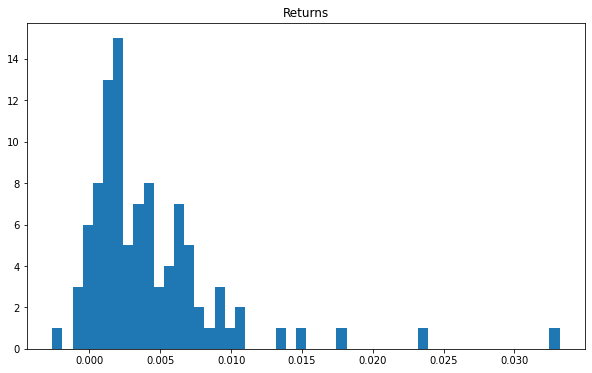

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(data_high_vol['return_pct'], bins=50)
plt.title('Returns')
plt.show()

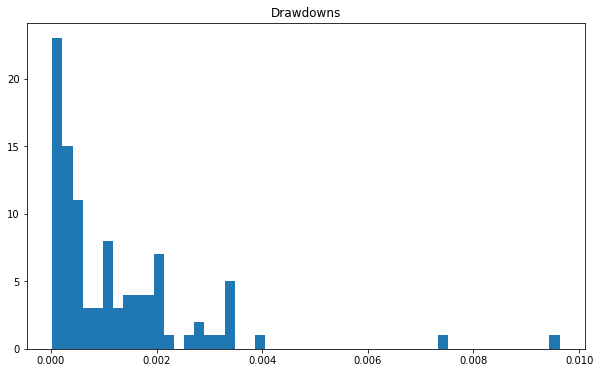

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(data_high_vol['darwdown'], bins=50)
plt.title('Drawdowns')
plt.show()

In [14]:
max_drawdown = 0.1

In [31]:
data_high_vol['darwdown'].mean() + 5 * data_high_vol['darwdown'].std()

0.008511401901296836

In [19]:
leverage = max_drawdown / (data_high_vol['darwdown'].mean() + 5 * data_high_vol['darwdown'].std())
leverage

11.748945844604465

In [22]:
leverage = 5

In [23]:
taker_fee = 0.00055

<AxesSubplot:xlabel='time'>

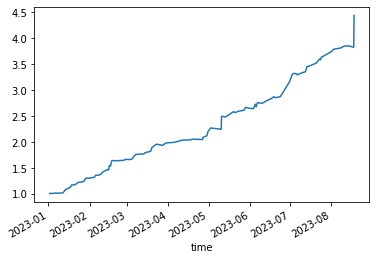

In [24]:
(leverage * (data_high_vol['return_pct'] - 2 * taker_fee) + 1).cumprod().plot()

In [28]:
start_cash = 1000
risk = 1
leverage = 10
pf = Portfolio(start_cash=start_cash, max_pos_pct=1, max_leverage=100, maker_fee=0.0002, taker_fee=0.00055)

t = 1
for idx, candle in data_high_vol.iterrows():
    print(f'{t} / {data_high_vol.shape[0]}')
    t += 1
    entry_range = candle['candle_size_mean'] + std_multiple * candle['candle_size_std']
    
    start_date = idx - datetime.timedelta(minutes=tf_hours * 60)
    end_date = idx - datetime.timedelta(minutes=1)
    data_1m = Dataset().get_data(ticker='BTCUSDT', interval='1m', start_date=start_date.strftime('%Y-%m-%d %H:%M:%S'),
                                 end_date=end_date.strftime('%Y-%m-%d %H:%M:%S'))
    for i in data_1m.index:
        data_1m.loc[i, 'roll_high'] = data_1m.loc[:i]['high'].max()
        data_1m.loc[i, 'roll_low'] = data_1m.loc[:i]['low'].min()
    data_1m['roll_candle_size'] = data_1m['roll_high'] - data_1m['roll_low']
    rough_price = data_1m[data_1m['roll_candle_size'] > entry_range].iloc[0]['close']
    
    if rough_price > candle['open']:
        entry = candle['low'] + entry_range
        exit = candle['close']
        
        pf.open_trade(entry, sl=1000000, tp=0, date=idx, risk=risk, lev=leverage)
        if exit <= entry:
            pf.take_profit(tp=exit, date=idx, order_type='market')
        else:
            pf.stop_loss(sl=exit, date=idx)
        
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (entry - exit) / entry
        data_high_vol.loc[idx, 'darwdown'] = (candle['high'] - entry) / entry
    elif rough_price < candle['open']:
        entry = candle['high'] - entry_range
        exit = candle['close']
        
        pf.open_trade(entry, sl=0, tp=1000000, date=idx, risk=risk, lev=leverage)
        if exit >= entry:
            pf.take_profit(tp=exit, date=idx, order_type='market')
        else:
            pf.stop_loss(sl=exit, date=idx)  
        
        data_high_vol.loc[idx, 'entry'] = entry
        data_high_vol.loc[idx, 'exit'] = exit
        data_high_vol.loc[idx, 'return_pct'] = (exit - entry) / entry
        data_high_vol.loc[idx, 'darwdown'] = (entry - candle['low']) / entry
    else:
        data_high_vol.loc[idx, 'entry'] = np.nan
        data_high_vol.loc[idx, 'exit'] = np.nan
        data_high_vol.loc[idx, 'return_pct'] = 0
        data_high_vol.loc[idx, 'darwdown'] = 0

1 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

2 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

3 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

4 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

5 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

6 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

7 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

8 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

9 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

10 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

11 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

12 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

13 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

14 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

15 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

16 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

17 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

18 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

19 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

20 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

21 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

22 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

23 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

24 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

25 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

26 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

27 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

28 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

29 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

30 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

31 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

32 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

33 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

34 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

35 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

36 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

37 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

38 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

39 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

40 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

41 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

42 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

43 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

44 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

45 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

46 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

47 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

48 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

49 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

50 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

51 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

52 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

53 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

54 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

55 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

56 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

57 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

58 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

59 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

60 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

61 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

62 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

63 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

64 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

65 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

66 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

67 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

68 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

69 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

70 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

71 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

72 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

73 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

74 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

75 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

76 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

77 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

78 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

79 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

80 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

81 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

82 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

83 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

84 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

85 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

86 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

87 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

88 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

89 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

90 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

91 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

92 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

93 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

94 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

95 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

96 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

97 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

98 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

99 / 99


C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'entry'] = entry
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[idx, 'exit'] = exit
C:\Users\aeali\AppData\Local\Temp\ipykernel_14616\3273599963.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_high_vol.loc[i

In [29]:
pf.trade_ts

,position,size,open_date,close_date,entry,sl,tp,result,balance
0,short,10000,2023-01-02 04:00:00,2023-01-02 04:00:00,16699.523468,1000000,16661.94,win,1011.505713
1,long,10115.05713,2023-01-03 15:00:00,2023-01-03 15:00:00,16638.38593,0,16661.23,win,1014.26686
2,short,10142.668598,2023-01-06 14:00:00,2023-01-06 14:00:00,16811.428637,1000000,16774.19,win,1025.576733
3,short,10255.76733,2023-01-08 16:00:00,2023-01-08 16:00:00,17018.270761,1000000,17000.43,win,1025.046816
4,short,10250.468157,2023-01-12 00:00:00,2023-01-12 00:00:00,17979.103487,1000000,17943.26,win,1034.206832
...,...,...,...,...,...,...,...,...,...
94,long,136192.564246,2023-08-07 16:00:00,2023-08-07 16:00:00,28791.023011,0,28858.44,win,13788.352781
95,long,137883.527807,2023-08-10 15:00:00,2023-08-10 15:00:00,29403.972693,0,29495.76,win,14067.09749
96,short,140670.9749,2023-08-14 03:00:00,2023-08-14 03:00:00,29355.343719,1000000,29319.99,win,14081.774642
97,long,140817.746422,2023-08-17 16:00:00,2023-08-17 16:00:00,27940.420109,27934.02,1000000,lose,13894.619022
